# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from datetime import date
import matplotlib.pyplot as plt
% matplotlib inline


UsageError: Line magic function `%` not found.


In [31]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript = transcript[['event', 'person', 'time', 'value']]

In [32]:
print(transcript.isna().sum())
print(profile.isna().sum())
print(portfolio.isna().sum())

event     0
person    0
time      0
value     0
dtype: int64
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


In [33]:
profile.dropna(inplace = True)

In [34]:
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))

In [35]:
print(profile.head())
print(portfolio.head())
print(transcript.head())

   gender  age                                id became_member_on    income
1       F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0
3       F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0
5       M   68  e2127556f4f64592b11af22de27a7932       2018-04-26   70000.0
8       M   65  389bc3fa690240e798340f5a15918d5c       2018-02-09   53000.0
12      M   58  2eeac8d8feae4a8cad5a6af0499a211d       2017-11-11   51000.0
   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56

In [36]:
portfolio = portfolio.rename(columns = {'duration':'duration_hours'})
portfolio = portfolio.rename(columns = {'id':'offer_id'})
profile = profile.rename(columns = {'id': 'customer_id'})

In [37]:
portfolio['duration_hours'] = portfolio['duration_hours'].apply(lambda x: 24*x)

In [38]:
max_date = profile['became_member_on'].max()
min_date = profile['became_member_on'].min()
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: (max_date - x).days / (max_date-min_date).days)
profile = profile.rename(columns = {'became_member_on': 'member_for_days'})

In [39]:
def scale_column(df, column_name):
    scaler = MinMaxScaler()
    df[column_name] = scaler.fit_transform(df[column_name].values.reshape(-1, 1))

scale_column(profile, 'income')
scale_column(profile, 'age')
scale_column(portfolio, 'difficulty')
scale_column(portfolio, 'reward')

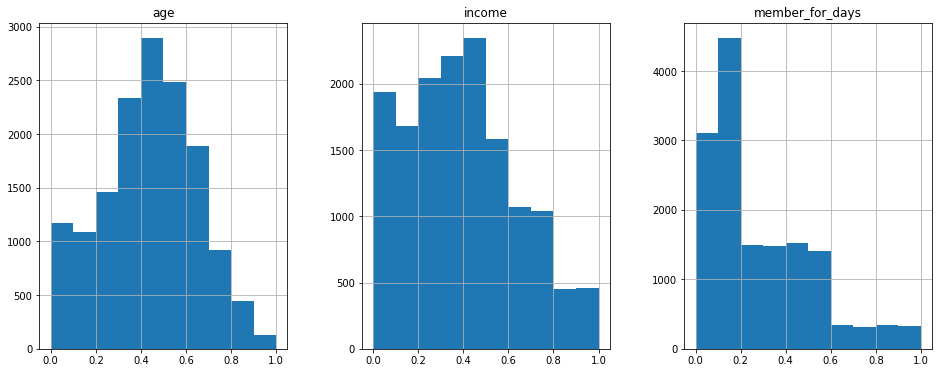

In [40]:
hist = profile.hist(figsize = (16,6), layout = (1,3))

In [41]:
def one_hot_encode(df, column_name):
    value = df[column_name].values[0]
    if hasattr(value, "__iter__") and type(value) is not str:
        all_values = df[column_name].apply(lambda x: tuple(x)).unique()
        unique_values = set([])
        for i in all_values:
            for j in i:
                unique_values.add(j)
        for i in unique_values:
            df[i] = df[column_name].apply(lambda x:1 if i in x else 0)
    else:
        unique_values = df[column_name].unique()
        for i in unique_values:
            df[i] = df[column_name].apply(lambda x:1 if x==i else 0)
            
    df.drop(columns = [column_name], inplace = True)
    

In [42]:
one_hot_encode(portfolio, 'channels')
one_hot_encode(portfolio, 'offer_type')
one_hot_encode(profile, 'gender')

In [43]:
portfolio.head()

,reward,difficulty,duration_hours,offer_id,social,email,web,mobile,bogo,informational,discount
0,1.0,0.50,168,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1,1,0,0
1,1.0,0.50,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0.0,0.00,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,1,0
3,0.5,0.25,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,1,1,0,0
4,0.5,1.00,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0,0,0,1


In [44]:
test_dict = {'mitro':[1,2,4]}
test_value = test_dict.get('mitro')
test_value[1] = 8
print(test_dict)

{'mitro': [1, 8, 4]}


In [45]:
def calculate_responses_and_spending(transcript, portfolio):
    info_df = portfolio.loc[portfolio['informational'] == 1]
    info_ids = info_df['offer_id'].values
    info_duration = info_df['duration_hours'].values
    
    columns = ['offer_id', 'customer_id', 'viewed', 'completed']
    index = 0
    offer_dict = {}
    list = []
    spent_dict = {}
    for log in transcript.values:
            
        person_id = log[1]
        if log[0] == 'offer received':
            offer_id = log[3]['offer id']
            offer_dict[f'{offer_id}_{person_id}'] = [0, 0]
            for i in range(len(info_ids)):
                if offer_id == info_ids[i]:
                    hour_end = info_duration[i] + log[2] 
                    offer_dict[f'{offer_id}_{person_id}'].extend([hour_end+1, hour_end])
        elif log[0] == 'offer viewed':
            offer_id = log[3]['offer id']
            offer_dict[f'{offer_id}_{person_id}'][0] = 1
            for i in range(len(info_ids)):
                if offer_id == info_ids[i]:
                    offer_dict[f'{offer_id}_{person_id}'][2] = log[2]
        elif log[0] == 'offer completed':
            offer_id = log[3]['offer_id']
            offer_dict[f'{offer_id}_{person_id}'][1] = 1
        elif log[0] == 'transaction':
            amount = log[3]['amount']
            try:
                spent_dict[person_id] += amount
            except KeyError:
                spent_dict[person_id] = amount
            for i in info_ids:
                temp_list = offer_dict.get(f'{i}_{person_id}')
                if temp_list and log[2] >= temp_list[2] and log[2] <= temp_list[3]:
                    temp_list[1] = 1
        else:
            print(log[0])
            raise Exception('Unknown event')
        
    for k,v in offer_dict.items():

        und_index = k.index('_')
        offer_id = k[:und_index]
        person_id = k[und_index+1:]
        list.append([offer_id, person_id, v[0], v[1]])
    offer_responses = pd.DataFrame(columns = columns, index = range(len(list)), data = list)
    offer_responses['total_amount'] = offer_responses['customer_id'].apply(lambda x: spent_dict.get(x) if spent_dict.get(x) else 0)

    return offer_responses

In [46]:
%%time
bruh = calculate_responses_and_spending(transcript, portfolio)
scale_column(bruh, 'total_amount')

CPU times: user 1.21 s, sys: 1.65 ms, total: 1.21 s
Wall time: 1.21 s


In [47]:
bruh.describe()

,viewed,completed,total_amount
count,63288.000000,63288.000000,63288.000000
mean,0.756320,0.520557,0.066162
std,0.429305,0.499581,0.079329
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.013850
50%,1.000000,1.000000,0.043999
75%,1.000000,1.000000,0.094282
max,1.000000,1.000000,1.000000


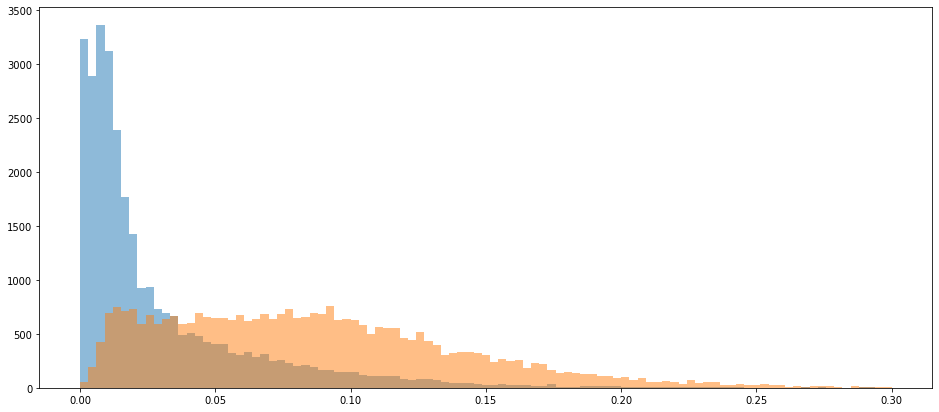

In [48]:
#bruh.loc[bruh['completed'] == 0].hist(column = ['total_amount'], bins = 50, figsize = [18,6])
plt.figure(figsize = [16,7])
test_amount_values = bruh.loc[bruh['completed'] == 0]['total_amount'].values
test_2_values = bruh.loc[bruh['completed'] == 1]['total_amount'].values
test_hist = plt.hist(test_amount_values, bins = np.linspace(0, 0.3,100), alpha = 0.5)
test_2hist = plt.hist(test_2_values, bins = np.linspace(0, 0.3,100), alpha = 0.5)
#plt.show()

In [36]:
bruh.loc[(bruh['viewed'] == 1) & (bruh['completed'] == 1)].count()

offer_id        28080
customer_id     28080
viewed          28080
completed       28080
total_amount    28080
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8598beb0b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f8598bc3e48>]], dtype=object)

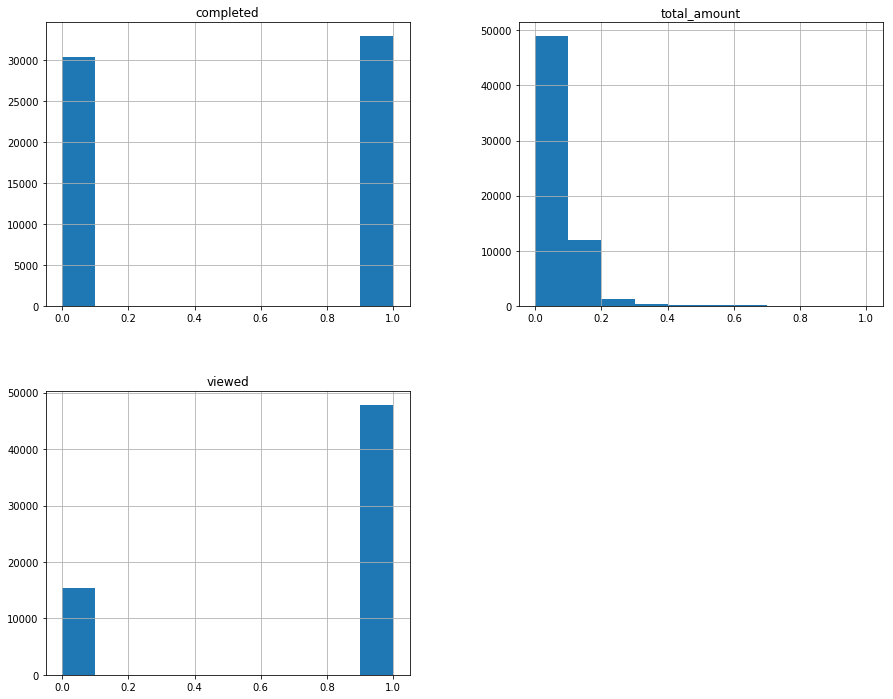

In [27]:
bruh.hist(figsize = (15, 12))

In [37]:
bruh.loc[bruh['completed'] == 1]['offer_id'].unique()

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       '3f207df678b143eea3cee63160fa8bed',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '2906b810c7d4411798c6938adc9daaa5',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2',
       '5a8bc65990b245e5a138643cd4eb9837'], dtype=object)

In [49]:
merged_df = profile.merge(bruh, on = ['customer_id']).merge(portfolio, on = ['offer_id'])

In [50]:
%%time
merged_df['responded'] = merged_df.apply(lambda x: int(x['viewed'] == 1 and x['completed'] == 1), axis = 1)

CPU times: user 1.54 s, sys: 5.29 ms, total: 1.54 s
Wall time: 1.54 s


In [51]:
merged_df.head()

,age,customer_id,member_for_days,income,F,M,O,offer_id,viewed,completed,...,difficulty,duration_hours,social,email,web,mobile,bogo,informational,discount,responded
0,0.445783,0610b486422d4921ae7d2bf64640c50b,0.206253,0.911111,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,...,0.25,168,0,1,1,1,1,0,0,0
1,0.686747,78afa995795e4d85b5d9ceeca43f5fef,0.243006,0.777778,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,0.25,168,0,1,1,1,1,0,0,1
2,0.602410,e2127556f4f64592b11af22de27a7932,0.049918,0.444444,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,0.25,168,0,1,1,1,1,0,0,1
3,0.566265,389bc3fa690240e798340f5a15918d5c,0.091607,0.255556,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,...,0.25,168,0,1,1,1,1,0,0,1
4,0.469880,6445de3b47274c759400cd68131d91b4,0.113549,0.133333,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,...,0.25,168,0,1,1,1,1,0,0,0


In [52]:
merged_df.drop(columns = ['customer_id', 'offer_id', 'viewed', 'completed'], inplace = True)

In [54]:
cols = merged_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols
merged_df = merged_df[cols]

In [55]:
X = merged_df.values[:, 1:]
y = merged_df.values[:, 0]
y

array([0., 1., 1., ..., 0., 0., 1.])

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)


In [57]:
logreg = LogisticRegression()

logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)
y_pred

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([0., 0., 0., ..., 0., 1., 1.])

In [58]:
test_coef = np.sort(logreg.coef_)
test_coef

array([[-1.26727624, -1.1296504 , -0.84500965, -0.6266532 , -0.53802225,
        -0.35483856, -0.15557948, -0.15140792,  0.00706132,  0.11496115,
         0.13648211,  0.13873289,  0.29005923,  0.40356602,  1.19347512,
         1.48693732,  5.56729781]])

In [59]:
accuracy_score(y_test, y_pred)

0.6785008779631255

In [55]:
merged_no_port.loc[(merged_no_port['viewed'] == 0) & (merged_no_port['completed'] == 1)].count()

age                4761
member_for_days    4761
customer_id        4761
income             4761
F                  4761
M                  4761
O                  4761
offer_id           4761
viewed             4761
completed          4761
total_amount       4761
dtype: int64

In [49]:
print(bruh.shape)
print(merged_no_port.shape)

(63288, 5)
(55222, 11)


In [29]:
merged_df.describe()

,age,member_for_days,income,F,M,O,viewed,completed,total_amount,difficulty,duration_hours,reward,social,mobile,web,email,bogo,informational,discount
count,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.0,55222.000000,55222.000000,55222.000000
mean,0.437951,0.285942,0.393207,0.413024,0.573051,0.013926,0.749339,0.568578,0.074085,0.385928,156.197747,0.420474,0.599181,0.898808,0.799337,1.0,0.399515,0.199938,0.400547
std,0.209551,0.230027,0.240293,0.492381,0.494639,0.117183,0.433398,0.495279,0.081843,0.277399,52.935753,0.340230,0.490069,0.301585,0.400500,0.0,0.489803,0.399957,0.490014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,0.289157,0.113549,0.211111,0.000000,0.000000,0.000000,0.000000,0.000000,0.019929,0.250000,120.000000,0.200000,0.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000
50%,0.445783,0.195831,0.366667,0.000000,1.000000,0.000000,1.000000,1.000000,0.055026,0.500000,168.000000,0.500000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000
75%,0.578313,0.436643,0.555556,1.000000,1.000000,0.000000,1.000000,1.000000,0.101990,0.500000,168.000000,0.500000,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,240.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


In [59]:
print(transcript.loc[transcript['event'] == 'offer received'].count()[0])
print(transcript.loc[transcript['event'] == 'offer viewed'].count()[0])
print(transcript.loc[transcript['event'] == 'offer completed'].count()[0])


76277
57725
33579


NameError: name 'test_1_values' is not defined

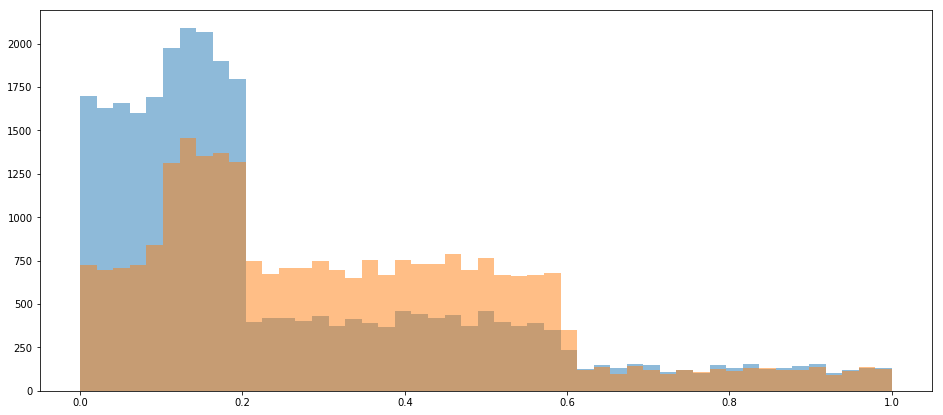

In [131]:

plt.figure(figsize = [16,7])
test_amount_values = merged_no_port.loc[merged_no_port['responded'] == 0]['member_for_days'].values 
test_2_values = merged_no_port.loc[merged_no_port['responded'] == 1]['member_for_days'].values
test_hist = plt.hist(test_amount_values, bins = np.linspace(0, 1,50), alpha = 0.5, label = 'No')
test_2hist = plt.hist(test_2_values, bins = np.linspace(0, 1,50), alpha = 0.5, label = 'Yes')
plt.legend()